# Библиотеки

Ставим библиотеки (тут конечно перебор, но на всякий случай делалось с избытком)

In [1]:
!pip install -q unsloth
!pip install --no-deps -q xformers trl peft accelerate bitsandbytes
!pip install -q transformers accelerate bitsandbytes pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 6.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 100.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 13.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 3

In [2]:
import pandas as pd
import re
import os
from tqdm.auto import tqdm
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
import gc

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-09-17 10:23:04.408894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758104584.748652      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758104584.852340      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


# Подгрузка и обработка данных

In [2]:
def prepare_reviews_from_txt(file_path: str) -> pd.DataFrame:
    # очистка данных ()
    if not os.path.exists(file_path):
        print(f"Ошибка: Файл не найден по пути {file_path}")
        return pd.DataFrame()

    df = pd.read_csv(file_path, names=['original_text'], on_bad_lines='skip', skiprows=1)
    df['clean_text'] = df['original_text'].str.lower()
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'([.!?,,;:])\1+', r'\1', x))
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'([.!?,,;:])', r' \1 ', x))
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
    df['clean_text'] = df['clean_text'].str.strip()
    print(f"Загружено и обработано {len(df)} отзывов.")
    return df[['original_text', 'clean_text']]

Немного почистили данные от мусора

In [3]:
train = prepare_reviews_from_txt("/kaggle/input/nlp-tink-otbor/train.csv")
test = prepare_reviews_from_txt("/kaggle/input/nlp-tink-otbor/test.csv")

Загружено и обработано 1818 отзывов.
Загружено и обработано 7276 отзывов.


In [4]:
test.head()

,original_text,clean_text
0,Советую продавца,советую продавца
1,По вашему это платье???? Это узкая кофта !!!! ...,по вашему это платье ? это узкая кофта ! за та...
2,Жуткая синтетика. Неприятная ткань. Летом не п...,жуткая синтетика . неприятная ткань . летом не...
3,"Джемперок так себе на хилую четверку,запах гол...","джемперок так себе на хилую четверку , запах г..."
4,"обычная х/б рубашка.не плотная,просвечивает ни...","обычная х/б рубашка . не плотная , просвечивае..."


In [5]:
train["clean_text"][5]

'обычная майка с ужасным запахом , есть косяки на белой надписи как краска'

# Zero-shot разметка

## Подход через zero-shot encoder-only модель

In [ ]:
from transformers.pipelines import pipeline
# подгружаем модельку
classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    device=0
)
print("classifier ready")

reviews = train["clean_text"].tolist()
candidate_labels = [
    'бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль',
    'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара'
]

# Классифицируем
results = classifier(reviews, candidate_labels, multi_label=False, batch_size=32)

train_marked = train.copy()
train_marked['predicted_category'] = [res['labels'][0] for res in results]

needs_check_flags = [
    (res['scores'][0] - res['scores'][1] < 0.2) or (res['scores'][0] < 0.5)
    for res in results
]

train_marked['needs_manual_check'] = needs_check_flags


# Выводим результат
for review, result in zip(reviews[:5], results[:5]):
    print(f"Отзыв: {review}")
    print(f"Предсказанная категория: {result['labels'][0]}")
    print(f"Уверенность: {result['scores'][0]}")
    print(f"Ручная проверка? {result['scores'][0] - result['scores'][1] < 0.2 or result['scores'][0] < 0.5}\n")

train_marked.head()

In [ ]:
num_to_check = train_marked['needs_manual_check'].sum()
total_reviews = len(train_marked)

print(f"Общее количество отзывов: {total_reviews}")
print(f"Всего отзывов для ручной проверки: {num_to_check}")

# Рассчитаем процент, чтобы оценить объем работы
if total_reviews > 0:
    percentage_to_check = (num_to_check / total_reviews) * 100
    print(f"Процент для проверки: {percentage_to_check:.2f}%")

Судя по результатам (почти 40% размеченных данных ненадежны) разметка очень так себе. Учитывая что в трейн датасете фактически всего два класса - одежда и нет товара (ну вот например 'За 4 месяца товар так и не дошел до покупателя.'), использовать zero-shot encoder-only модель это неудачное решение.
Так что вместо encoder-only моделей разметим данные при помощи decoder-only моделей

In [ ]:
print(train_marked['predicted_category'].value_counts())

In [ ]:
train_marked[train_marked['predicted_category'] == "нет товара"]['original_text'].tolist()

In [ ]:
train_marked.to_csv("output.csv")

Формально я конечно результаты сохранил, но они мусорные

## Подход через Autoreg модели

Очевидным решением является использовать decoder-only модели - все же они сильно мощнее, чем encoder-only для задачи zero-shot классификации. в нашем случае я выбрал семейство моделей Qwen3 - open-source модели от Alibaba, которые хорошо справляются с разными языками и обладают большим количеством вариаций по размеру.  
Проблема лишь только в том, что почти любые современные decoder-only модели требуют ОЧЕНЬ много ресурсов. Чтобы на всех этапах влезть в ограничения (ресурсы - видеокарта T4 16 GB VRAM), было два пути:
* использовать маленькие LLM (в нашем случае Qwen3-4B)
* использовать средние LLM (Qwen3-14B) с агрессивной оптимизацией, в частности с использованием unsloth (он в свою очередь использует разные трюки, включая динамическую квантизацию, но не ограничиваясь ей)  
На практике второй вариант оказался предпочтительнее - даже сильно оптимизированные средние модели показывают себя куда лучше маленьких

Подгрузка модели

In [9]:
MODEL_NAME = "Qwen/Qwen3-14B"
BATCH_SIZE = 4
REVIEWS_PER_SEED = 10
OUTPUT_FILENAME = "synthetic_reviews_dataset_v2.csv"
print(f"Загрузка модели: {MODEL_NAME}")
# Создаем конфигурацию для 4-битной квантизации через BitsAndBytes
max_seq_length = 1024 # Можно оставить по умолчанию или задать свое
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = max_seq_length,
    dtype = None, # None означает автовыбор (bfloat16 для Ampere, float16 для Volta/Turing)
    load_in_4bit = True,
)
print("Модель успешно загружена и оптимизирована Unsloth!")
print("Модель успешно загружена в 4-битном формате!")

Загрузка модели: Qwen/Qwen3-14B
==((====))==  Unsloth 2025.9.5: Fast Qwen3 patching. Transformers: 4.56.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Модель успешно загружена и оптимизирована Unsloth!
Модель успешно загружена в 4-битном формате!


## Промптинг

In [8]:
def make_prompt(review_text: str) -> str:
    return f'''Классифицируй отзыв 
    {review_text}"
    '''

In [14]:
old_prompt = '''Ты — эксперт по классификации отзывов на товары. Твоя задача — определить, к какой из перечисленных категорий относится отзыв.

Категории:
- бытовая техника
- обувь
- одежда
- посуда
- текстиль
- товары для детей
- украшения и аксессуары
- электроника
- нет товара

Правила:
1.  Используй категорию "нет товара" в том случае, если отзыв невозможно отнести к какой-либо другой категории, то есть если нет конкретного контекста, указывающего на какую-либо категорию (например: "Все пришло вовремя, спасибо магазину!", "Товар не пришел, деньги не вернули!").
2.  Не используй свой опыт, опирайся исключительно на текст отзыва.
3.  Упоминание трека/доставки/возврата/оплаты/сервиса само по себе не является поводом выбрать какую-либо категорию — в таких случаях выбирай "нет товара".

Формат ответа:
Твой ответ должен состоять строго из двух строк.
Первая строка: название категории.
Вторая строка: краткое пояснение выбора (1-2 предложения).

Пример формата:
"одежда"
"В отзыве упоминается 'платье' и 'размер', что напрямую указывает на категорию 'одежда'."'''

Изначально я пробовал крутить этот промпт (сверху), но модель приницпиально не хотела выводить все так, как нужно. До этого были попытки сделать без пояснения, но пояснение в 1-2 предложения радикально улучшило качество вывода (теоретически того же результата можно достичь включив режим размышлений у исходной модели, однако, это требует значительного увеличения числа новых токенов, а соответственно сильно снижает общую производительность)

In [3]:
system_prompt = '''Ты — точный классификатор отзывов на товары. Твоя задача — определить категорию товара по тексту отзыва и дать краткое пояснение.

**Категории на выбор:**
- бытовая техника
- обувь
- одежда
- посуда
- текстиль
- товары для детей
- украшения и аксессуары
- электроника
- нет товара

**Ключевые правила:**
1.  Выбирай категорию "нет товара", если в отзыве говорится только о доставке, оплате, возврате или общих впечатлениях без упоминания конкретного товара.
2.  Опирайся СТРОГО на слова в тексте отзыва. Не додумывай.
3.  Твой ответ должен состоять ровно из двух строк строго согласно примерам. Без номеров, без лишних слов.

---

**Примеры того, как должен выглядеть твой ответ:**

**Пример 1:**
*Отзыв:* "Платье красивое, но с размером не угадала."
*Твой ответ:*
"одежда"
"В отзыве упоминается 'платье' и 'размер', что указывает на эту категорию."

**Пример 2:**
*Отзыв:* "Посылку так и не доставили, поддержка молчит."
*Твой ответ:*
"нет товара"
"В отзыве говорится только о доставке, а не о конкретном товаре."

**Пример 3:**
*Отзыв:* "Купил новые кроссовки для бега, очень удобные."
*Твой ответ:*
"обувь"
"Ключевое слово 'кроссовки' напрямую относится к категории 'обувь'."'''

С таким промптом модель прекратила игру в шизофрению с приколами типа


> обувь
> 
> Но в отзыве упоминаются только вещи относящиеся к одежде
> 
> Одежда

И стала выводить адекватные ответы

Пока я не сделал все батчем, что насмерть испортило результаты (что странно и честно говоря объяснению не поддается)

In [10]:
system_prompt = '''Ты — точный ИИ-классификатор отзывов. Твоя задача — вернуть категорию и пояснение в СТРОГОМ формате.

**Категории на выбор:**
- бытовая техника
- обувь
- одежда
- посуда
- текстиль
- товары для детей
- украшения и аксессуары
- электроника
- нет товара

**СТРОГИЕ ПРАВИЛА:**
1.  Выбирай категорию "нет товара", если в отзыве говорится только о доставке, оплате, спорах или общих фразах ("все хорошо").
2.  Опирайся ТОЛЬКО на слова в тексте. Не додумывай.
3.  В строке `КАТЕГОРИЯ:` должно быть ТОЛЬКО одно название из списка выше. Никаких лишних слов вроде "среди" или "похоже на".
4.  Твой ответ ДОЛЖЕН СТРОГО следовать формату с метками `КАТЕГОРИЯ:` и `ПОЯСНЕНИЕ:`.

---

**Примеры формата, которому ты должен следовать:**

**Пример 1:**
*Отзыв:* "Платье красивое, но с размером не угадала."
*Твой ответ:*
КАТЕГОРИЯ: одежда
ПОЯСНЕНИЕ: В отзыве упоминается "платье", что напрямую указывает на категорию "одежда".

**Пример 2:**
*Отзыв:* "Посылку так и не доставили, поддержка молчит."
*Твой ответ:*
КАТЕГОРИЯ: нет товара
ПОЯСНЕНИЕ: В отзыве говорится только о проблемах с доставкой, а не о самом товаре.

**Пример 3:**
*Отзыв:* "Купил новые кроссовки для бега, очень удобные."
*Твой ответ:*
КАТЕГОРИЯ: обувь
ПОЯСНЕНИЕ: Ключевое слово "кроссовки" однозначно относится к категории "обувь".'''

Итоговый промпт выглядел так, он позволил получить достаточно хорошее качество

## Инференс для разметки
Наконец подобрались к наиболее неприятному но важному моменту - автоматической разметке данных. Теоретически в данном случае можно было внедрить систему активного обучения, что можно рассмотреть при дальнейшей работе

Тестовый пуск на одном отзыве

In [11]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": make_prompt(train["clean_text"][46])}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False
)
model_inputs = tokenizer([text], return_tensors="pt").to("cuda")

generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=256,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)

КАТЕГОРИЯ: одежда  
ПОЯСНЕНИЕ: В отзыве упоминается "ткань", "размер S" и "длина", что явно относится к категории "одежда".


In [12]:
train["clean_text"][46]

'ткань довольно тонкая , но я брала для косплея , так что норм . размер s на мои 91-66-97 довольно свободно висит , на рост ~170 по длине великовато'

Результат обнадеживающий :)
Запустим на всем датасете с батчем 8 (иначе ждать ну слишком долго, тем более памяти хватает)

In [15]:
BATCH_SIZE = 8

results = []
with torch.no_grad():
    for i in tqdm(range(0, len(train), BATCH_SIZE)):
        batch_texts = train["clean_text"][i:i + BATCH_SIZE].tolist()
        
        batch_messages = []
        for text in batch_texts:
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": make_prompt(text)} 
            ]
            batch_messages.append(messages)

        templated_texts = [
            tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=False)
            for msgs in batch_messages
        ]
        
        model_inputs = tokenizer(
            templated_texts, 
            return_tensors="pt", 
            padding=True
        ).to(model.device)
        
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=512,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id
        )
        input_ids_len = model_inputs.input_ids.shape[1]
        decoded_responses = tokenizer.batch_decode(
            generated_ids[:, input_ids_len:], 
            skip_special_tokens=True
        )
        
        results.extend(decoded_responses)

# print("\n".join(results))
marked_train = train.copy(deep=True)
marked_train['model_response'] = results
print("Инференс завершен!")
print(marked_train.head())
marked_train.to_csv("marked_qwen3_14b_unsloth.csv")

  0%|          | 0/228 [00:00<?, ?it/s]

Инференс завершен!
                                       original_text  \
0  Заказали 14.10.2017 , получили 25.10.2017 \r\n...   
1  футболка хорошего качества,но футболка не как ...   
2                                     Все отлично!!!   
3  Рисунок не очень чёткий, а ткань прозрачная, в...   
4  плохо!!!Низ рваный..деньги не вернули!Открыла ...   

                                          clean_text  \
0  заказали 14 . 10 . 2017 , получили 25 . 10 . 2...   
1  футболка хорошего качества , но футболка не ка...   
2                                      все отлично !   
3  рисунок не очень чёткий , а ткань прозрачная ,...   
4  плохо ! низ рваный . деньги не вернули ! откры...   

                                      model_response  
0  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
1  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
2  КАТЕГОРИЯ: нет товара  \nПОЯСНЕНИЕ: В отзыве и...  
3  КАТЕГОРИЯ: одежда  \nПОЯСНЕНИЕ: В отзыве упоми...  
4  КАТЕГОРИЯ: нет товара  \nПОЯС

Замечу что я специально указал модели не заниматься размышлениями - это слишком затратно по времени

In [16]:
from IPython.display import FileLink

# Создаем ссылку для скачивания
display(FileLink("marked_qwen3_14b_unsloth.csv", result_html_prefix="Нажмите чтобы скачать: "))

/kaggle/working/marked_qwen3_14b_unsloth.csv

In [18]:
print("\n".join(marked_train[15:16]["model_response"].tolist()))

среди

КАТЕГОРИЯ: одежда  
ПОЯСНЕНИЕ: В отзыве упоминается "куртка", что является частью категории "одежда".


Для примера выводим что-то из сгенерированного. Видим небольшие затупы, но судя по пояснению все должно быть нормально

# Генерация данных на редкие классы 

А с этого момента начинается АД  
В ноутбуке с анализом отмечено, что у нас вообще говоря большие проблемы с разнообразием данных: у нас попросту практически нет данных на 7 классов из 9, что КРАЙНЕ плохо. Поэтому было решено сгенерировать синтетические данные, делать это будем той же моделью Qwen3-14B. 

In [13]:
# КОНФИГУРАЦИЯ
MODEL_NAME = "Qwen/Qwen3-14B"
BATCH_SIZE = 4
REVIEWS_PER_SEED = 10
OUTPUT_FILENAME = "synthetic_reviews_dataset_v2.csv"

In [14]:
print(f"Загрузка модели: {MODEL_NAME}")
max_seq_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)
print("Модель успешно загружена и оптимизирована Unsloth!")

Загрузка модели: Qwen/Qwen3-14B
==((====))==  Unsloth 2025.9.6: Fast Qwen3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Модель успешно загружена и оптимизирована Unsloth!
Модель успешно загружена в 4-битном формате!


In [16]:
# Портфель сидов для генерации
SEED_PORTFOLIO = {
    "одежда" : [
        "Платье просто супер! Ткань приятная к телу, не просвечивает, и село идеально по фигуре. Очень довольна покупкой.",
        "Заказала джинсы своего обычного размера, но они оказались ужасно маломерными. Еле налезли, пришлось оформлять возврат.",
        "После первой же деликатной стирки свитер покрылся катышками и потерял форму. Качество отвратительное, не стоит своих денег.",
        "Футболка как на фото. Цвет совпадает, размер соответствует таблице. Обычный хлопок, ничего особенного.",
        "Носила эту куртку всего месяц, а молния уже сломалась. Швы в некоторых местах тоже начали расходиться."
    ],
    "нет товара" : [
        "Заказ должен был прийти еще на прошлой неделе. Трек-номер не отслеживается, курьер не звонил. Где моя посылка?",
        "Коробка пришла вся мятая и вскрытая. Сам товар вроде не пострадал, но впечатление от сервиса испорчено.",
        "Оформил возврат две недели назад, товар отправил обратно. Деньги до сих пор не вернули на карту.",
        "Возник вопрос по заказу, написал в службу поддержки. Прошло три дня — ответа так и нет. Полный игнор.",
        "Все отлично, спасибо! Буду заказывать еще."
    ],
    "бытовая техника": [
        "Кофемашина — просто восторг! Каждое утро теперь начинается с идеального капучино. Не жалею ни копейки.",
        "Робот-пылесос реально экономит кучу времени. Запускаю, пока гуляю с собакой, прихожу — чистота.",
        "Тостер как тостер. Два слота, шесть режимов прожарки. Функцию свою выполняет, хлеб не жжет.",
        "В целом микроволновка неплохая, но греет как-то неравномерно: тарелка кипяток, а еда в центре холодная.",
        "Блендер сгорел при первом же использовании, когда пытался измельчить банан! Пошел дым, запахло паленым. Ужас.",
        "Утюг тяжеловат, рука устает, зато отпаривает даже самые плотные льняные шторы на ура."
    ],
    "обувь": [
        "Это лучшие кроссовки для бега, что у меня были. Амортизация превосходная, на ноге почти не чувствуются.",
        "Ботинки теплые, не скользят на льду, что для нашей зимы самое главное. Выглядят просто, но надежно.",
        "Тапочки домашние, размер 42, цвет серый. Соответствуют фото на сайте. Мягкие.",
        "Туфли красивые, но жутко жмут в подъеме, хотя это мой обычный размер. Надеюсь, разносятся.",
        "Лямка у босоножек оторвалась на второй день носки, прямо посреди улицы. Качество подвальное.",
        "Брал эти мокасины для вождения, у них тонкая и гибкая подошва, педали чувствуются отлично."
    ],
    "посуда": [
        "Тарелки просто произведение искусства! Глубокий синий цвет, неровные края — гости были в восторге.",
        "Наконец-то нашла контейнеры для еды, которые не протекают в сумке. Крышка закрывается очень плотно.",
        "Набор вилок, 6 штук. Сталь. Без царапин. Стандартные.",
        "Сковорода неплохая, но ручка немного люфтит. Пришлось самому подкручивать винт.",
        "Стеклянная кружка треснула, когда я налил в нее кипяток. Чуть не ошпарился. Опасно!",
        "Форма для выпечки хорошая, кексы не пригорают, но мыть ее в углах — целая история."
    ],
    "текстиль": [
        "Этот плед — само воплощение уюта. Мягкий, теплый, не электризуется. Вся семья за него борется.",
        "Кухонные полотенца из вафельной ткани. Отлично впитывают влагу и быстро сохнут, то что нужно.",
        "Простыня на резинке, 160х200, хлопок. На матрас высотой 20 см налезла.",
        "Цвет постельного белья в реальности оказался более блеклым и тусклым, чем на фото.",
        "После стирки скатерть села сантиметров на 15 и пошла волнами. Просто выкинутые деньги.",
        "Покупала эту ткань для пэчворка. Не линяет, срез не сыпется, работать с ней приятно."
    ],
    "товары для детей": [
        "Подарили дочке этот кукольный домик, она из своей комнаты теперь не выходит. Абсолютное счастье!",
        "Автокресло легко устанавливается, и главное, ребенку в нем удобно даже в долгой дороге. Не капризничает.",
        "Боди для новорожденного, 3 штуки в упаковке, 100% хлопок. Швы наружу, как и положено.",
        "В наборе для творчества оказалось очень мало пластилина, хватило буквально на одну поделку.",
        "У игрушечной машинки отвалилось колесо, которое ребенок чуть не проглотил! Острые края на пластике. Не покупайте!",
        "Пазл интересный, картинка красивая, но детали слишком туго вставляются, трехлетке без помощи не справиться."
    ],
    "украшения и аксессуары": [
        "Подвеска превзошла все ожидания! Выглядит очень нежно и дорого, камень на солнце просто горит.",
        "Рюкзак оказался на удивление вместительным и прочным. Ноутбук, документы, ланч-бокс — все влезает.",
        "Солнцезащитные очки, пластиковая оправа. Степень затемнения средняя. Для города подойдут.",
        "Ремень хороший, но пряжка слишком массивная и тяжелая, постоянно перевешивает и сползает.",
        "Покрытие с кольца начало облезать через три дня. Теперь оно какими-то пятнами. Выглядит ужасно.",
        "Шарф красивый, но очень колючий. Носить на голой шее невозможно, только поверх одежды."
    ],
    "электроника": [
        "Поставил этот SSD в старый ноутбук — он теперь просто летает! Загрузка системы за 10 секунд.",
        "Беспроводная мышка — это вещь. Никаких проводов на столе, подключилась сразу, батарейку держит долго.",
        "Кабель HDMI, длина 2 метра. Сигнал передает, картинка есть. Обычный кабель.",
        "Умные часы в целом неплохие, но шаги считают с большой погрешностью. Для спорта не очень подходят.",
        "Клавиатура постоянно теряет связь по Bluetooth с моим макбуком. Работать невозможно, сплошные нервы.",
        "Внешний жесткий диск быстрый, но требует дополнительного питания от розетки, а не только от USB. Не очень мобильно."
    ]
}

Как видим по промпту - подход на первом этапе был простой. Я написал несколько искуственных отзывов, на которые модель опиралась при генерации.

In [17]:
def create_diversified_prompt(category_name, seed_review, num_to_generate):
    return f"""**Твоя роль:** Ты — обычный человек, который пишет короткие отзывы о товарах в интернете. Твой язык — простой и разговорный.

**Твоя задача:** Напиши {num_to_generate} коротких, простых и правдоподобных отзывов о товарах из категории "{category_name}".

**Правила:**
1.  **НЕ ВЫДУМЫВАЙ НАЗВАНИЯ:** Запрещено придумывать названия для товаров в кавычках (например, НЕЛЬЗЯ писать `пылесос «Чистюля»` или `холодильник «Морозко»`). Говори просто: "этот пылесос", "моя новая микроволновка", "купил холодильник".
2.  **БЕЗ ФАНТАЗИИ И РЕКЛАМЫ:** Описывай только обычные, бытовые ситуации (купил, сломалось, удобно, не понравилось, доставили быстро). Никаких несуществующих функций.
3.  **БЕЗ ФОРМАЛИЗМА И КАНЦЕЛЯРИЗМА:** Используй простые слова. Например, вместо "функционирует" пиши "работает". Вместо "устройство" — "прибор" или название товара.
4.  **СТРОГО ДЕРЖИСЬ КАТЕГОРИИ:** Если категория "{category_name}", то пиши ТОЛЬКО о ней. Не упоминай инструменты, садовую технику, одежду или что-то еще.
5.  **БЕЗ ФОРМАТИРОВАНИЯ:** Не используй жирный шрифт, заголовки или звездочки.
6.  **РАЗНООБРАЗИЕ** Не используй товар из отзыва-примера  для генерации новых отзывов, но используй другие товары из той же категории. Старайся (при возможности) использовать слова не использованные в примере.
---
**Пример-ориентир (нужен ТОЛЬКО для понимания общего настроения — позитив/негатив):**
"{seed_review}"
---

**Твой результат ({num_to_generate} простых и реалистичных отзывов в виде нумерованного списка):**
"""

После чего промпты генерировались так, чтобы модель создавала сразу пачку отзывов по этой категории, опираясь на примеры. Это позволило ограничить модель в повторении одних и тех же слов и товаров (с чем сильно помог repetition penalty)

In [19]:
# ПОДГОТОВКА СПИСКА ЗАДАЧ ДЛЯ ГЕНЕРАЦИИ
all_prompts_with_categories = []
categories_to_generate = list(SEED_PORTFOLIO.keys())
for category in categories_to_generate:
    for seed_review in SEED_PORTFOLIO[category]:
        prompt = create_diversified_prompt(category, seed_review, REVIEWS_PER_SEED)
        all_prompts_with_categories.append({'prompt': prompt, 'category': category})
print(f"Подготовлено {len(all_prompts_with_categories)} задач на генерацию.")

Подготовлено 52 задач на генерацию.


Пример готового собранного промпта:

In [20]:
all_prompts_with_categories[0]

{'prompt': '**Твоя роль:** Ты — обычный человек, который пишет короткие отзывы о товарах в интернете. Твой язык — простой и разговорный.\n\n**Твоя задача:** Напиши 10 коротких, простых и правдоподобных отзывов о товарах из категории "одежда".\n\n**Правила:**\n1.  **НЕ ВЫДУМЫВАЙ НАЗВАНИЯ:** Запрещено придумывать названия для товаров в кавычках (например, НЕЛЬЗЯ писать `пылесос «Чистюля»` или `холодильник «Морозко»`). Говори просто: "этот пылесос", "моя новая микроволновка", "купил холодильник".\n2.  **БЕЗ ФАНТАЗИИ И РЕКЛАМЫ:** Описывай только обычные, бытовые ситуации (купил, сломалось, удобно, не понравилось, доставили быстро). Никаких несуществующих функций.\n3.  **БЕЗ ФОРМАЛИЗМА И КАНЦЕЛЯРИЗМА:** Используй простые слова. Например, вместо "функционирует" пиши "работает". Вместо "устройство" — "прибор" или название товара.\n4.  **СТРОГО ДЕРЖИСЬ КАТЕГОРИИ:** Если категория "одежда", то пиши ТОЛЬКО о ней. Не упоминай инструменты, садовую технику, одежду или что-то еще.\n5.  **БЕЗ ФОРМАТИ

In [23]:
# ОСНОВНОЙ ЦИКЛ ГЕНЕРАЦИИ
final_generated_data = []
with torch.no_grad():
    for i in tqdm(range(0, len(all_prompts_with_categories), BATCH_SIZE), desc="Генерация отзывов"):
        batch_data = all_prompts_with_categories[i:i + BATCH_SIZE]
        batch_prompts = [item['prompt'] for item in batch_data]
        batch_categories = [item['category'] for item in batch_data]

        batch_messages = [
            [{"role": "user", "content": prompt}] 
            for prompt in batch_prompts
        ]

        templated_texts = [
            tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=False)
            for msgs in batch_messages
        ]
        
        model_inputs = tokenizer(
            templated_texts, 
            return_tensors="pt", 
            padding=True
        ).to(model.device)
        
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=1024,
            temperature=0.85,
            top_p=0.9,
            repetition_penalty=1.2,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        
        input_ids_len = model_inputs.input_ids.shape[1]
        decoded_responses = tokenizer.batch_decode(
            generated_ids[:, input_ids_len:], 
            skip_special_tokens=True
        )
        for response_text, category in zip(decoded_responses, batch_categories):
            # response_no_thinking = response_text.split("</think>")[1]
            individual_reviews = re.split(r'\s*\d+\.\s*', response_text)
            for review in individual_reviews:
                cleaned_review = review.strip()
                if cleaned_review:
                    final_generated_data.append({
                        'generated_text': cleaned_review,
                        'category': category
                    })

# СОХРАНЕНИЕ РЕЗУЛЬТАТА
print("\nГенерация завершена!")

synthetic_df = pd.DataFrame(final_generated_data)
synthetic_df = synthetic_df.sample(frac=1).reset_index(drop=True)

print(f"Всего сгенерировано {len(synthetic_df)} отзывов.")
print("Пример сгенерированных данных:")
print(synthetic_df.head())

synthetic_df.to_csv(OUTPUT_FILENAME, index=False)
print(f"\n✅ Результат успешно сохранен в файл: {OUTPUT_FILENAME}")

Генерация отзывов:   0%|          | 0/13 [00:00<?, ?it/s]


Генерация завершена!
Всего сгенерировано 543 отзывов.
Пример сгенерированных данных:
                                      generated_text          category
0  Лёгкая кофта из коллекции весна-лето действите...            одежда
1  Конструктор из крупных элементов – безопасный,...  товары для детей
2  Колбасу нарезала этим стеклом – всё красиво, р...            посуда
3  Куртка-бomber кажется прочной, но застёжка рас...            одежда
4  Шторы держались плохо, через пару недель начал...          текстиль

✅ Результат успешно сохранен в файл: synthetic_reviews_dataset_v2.csv


In [24]:
synthetic_df[synthetic_df["category"] == 'одежда']["generated_text"].tolist()

['Лёгкая кофта из коллекции весна-лето действительно прохладная. Подходит как на работу, так и на отдых.',
 'Куртка-бomber кажется прочной, но застёжка расстегнулась уже после двух выходов. Буду проверять качество.',
 '�',
 'Ползунки детские оказались маленькие. Подрос малыш – значит, нужно было брать побольше.',
 'Мягкая кофта отлично согревает зимой. Покупкой доволен, особенно когда проходит морозная неделя.',
 'Брюки прямые, но я выбрала слишком большой размер. Они постоянно сползают вниз, хотя попробовала закрепить ластиковыми резинками.',
 'Рубашка была дороговата, но выглядит презентабельно. Единственный минус — сильно запахивает.',
 'ый',
 'Ползунки детские купила — все швы аккуратные, ткань плотная. Подходят для прогулок и спорта.',
 'Жилетка, которую взял, кажется, хорошего качества. Но она слишком теплая, даже летом в городе хватило.',
 'Пальто купил по акции – цена радует, но качество немного ниже среднего. Прошло полгода, а уже начались трещины на молнии.',
 'Джемпер был не

Видим, что в целом получилось что-то +- адекватное (местами есть артефакты, но это больше проблема с парсингом ответов без учета галлюцинаций). Однако, разнообразием они не блещут.

In [25]:
synthetic_df[synthetic_df["category"] == 'нет товара']["generated_text"].tolist()

['Устройство вроде нормальное, но после двух дней использования начало дребезжать. Похоже, качество ниже среднего.',
 'Отправили мне бракованный фена. Я его проверил — работает, но постоянно выключается само. Пришлось менять.',
 'Сделал заказ, а через пару дней понял, что его нет. Проверил сайт — тоже показывает, как будто ничего не было.',
 'На сайте написано, что духовка работает без провода. А я её всё равно заряжал. Получается, она все равно требует батарейки?',
 'Брали подарок к празднику. А перед тем, как получить, позвонили — сказали, что товар переключён. Выбрали другой вариант.',
 'Забрал свой заказ в пункте выдачи, а там спрашивают: «Вы точно этот товар выбрали? Его больше нет». Молчу…',
 'Пришёл курьер — сказал, что товар уже распродан. Я даже не успел обрадоваться, что он приехал.',
 'Прождал почти неделю, думал, всё приедет. А потом получил сообщение от продавца, что товар закончился. Обидно немного.',
 'Прямо в момент оформления заказа сказали, что товар закрыт. Перешёл н

In [28]:
synthetic_df = synthetic_df[synthetic_df['generated_text'].str.len() >= 5]

In [29]:
print(f"Всего сгенерировано {len(synthetic_df)} отзывов.")

Всего сгенерировано 520 отзывов.


In [31]:
synthetic_df.head()

,generated_text,category
0,Лёгкая кофта из коллекции весна-лето действите...,одежда
1,"Конструктор из крупных элементов – безопасный,...",товары для детей
2,"Колбасу нарезала этим стеклом – всё красиво, р...",посуда
3,"Куртка-бomber кажется прочной, но застёжка рас...",одежда
4,"Шторы держались плохо, через пару недель начал...",текстиль


In [33]:
synthetic_df.to_csv(OUTPUT_FILENAME, index=False)

# Улучшение полученных отзывов
Сделаем прогонку по всему сгенерированному датасету и попросим модель переписать отзывы другими словами и с другой семантикой, притом сделаем по две вариации, чтобы еще больше расширить датасет.

In [51]:
BATCH_SIZE = 8
VARIATIONS_PER_REVIEW = 2
AUGMENTED_OUTPUT_FILENAME = "augmented_reviews_dataset.csv"

Собственно промпт

In [42]:
def create_diversify_prompt(original_review, category_name, num_variations):
    return f"""**Твоя роль:** Ты — креативный редактор. Твоя задача — взять отзыв и переписать его несколькими совершенно разными способами, сохраняя основной смысл.

**Контекст:** Отзыв о товаре из категории "{category_name}".

**Оригинальный отзыв для переработки:**
"{original_review}"

**Твоя задача:** Напиши {num_variations} стилистически и лексически РАЗНЫХ версий этого отзыва. Сохрани ключевую идею и эмоциональный окрас (позитив/негатив/нейтральность), но измени всё остальное:
- **Структуру предложения:** начни с другой мысли, используй другие обороты.
- **Стиль:** попробуй написать то коротко и по-деловому, то более эмоционально и разговорно.
- **Словарь:** используй синонимы и разные выражения для описания той же самой проблемы или радости.
- **Длину:** сделай некоторые варианты короче оригинала, а некоторые — чуть более подробными.

**ВАЖНО:** Не выдумывай новые факты или детали, которых не было в оригинале.

**Твой результат ({num_variations} вариантов в виде нумерованного списка):**
Структура вывода:
1. **перефраз отзыва**
2. **другой перефраз отзыва**
"""

Подготовим задачи для генерации (в этот раз пачками собирать не будем, модель может запутаться)

In [43]:
all_diversify_tasks = []
print("Подготовка задач на основе вашего DataFrame...")
for index, row in synthetic_df.iterrows():
    original_text = row['generated_text']
    category = row['category']
    prompt = create_diversify_prompt(original_text, category, VARIATIONS_PER_REVIEW)
    all_diversify_tasks.append({
        'prompt': prompt,
        'category': category
    })

print(f"Подготовлено {len(all_diversify_tasks)} задач на диверсификацию.")

Подготовка задач на основе вашего DataFrame...
Подготовлено 520 задач на диверсификацию.


В этот момент начались проблемы с кешом, пришлось прикрутить сборщик мусора, чтобы использовать большой батч и не ждать до дедлайна и еще 115 часов

In [50]:
gc.collect()
torch.cuda.empty_cache()

In [53]:
final_diversified_data = []
# 
with torch.no_grad():
    for i in tqdm(range(0, len(all_diversify_tasks), BATCH_SIZE), desc="Диверсификация отзывов"):
        batch_data = all_diversify_tasks[i:i + BATCH_SIZE]
        batch_prompts = [item['prompt'] for item in batch_data]
        batch_categories = [item['category'] for item in batch_data]

        batch_messages = [
            [{"role": "user", "content": prompt}] 
            for prompt in batch_prompts
        ]

        templated_texts = [
            tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=False)
            for msgs in batch_messages
        ]
        
        model_inputs = tokenizer(
            templated_texts, 
            return_tensors="pt", 
            padding=True
        ).to(model.device)
        
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=1024,
            temperature=0.85,
            top_p=0.9,
            repetition_penalty=1.15,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        
        input_ids_len = model_inputs.input_ids.shape[1]
        decoded_responses = tokenizer.batch_decode(
            generated_ids[:, input_ids_len:], 
            skip_special_tokens=True
        )
        for response_text, category in zip(decoded_responses, batch_categories):
            # response_no_thinking = response_text.split("</think>")[1]
            individual_reviews = re.split(r'\s*\d+\.\s*', response_text)
            for review in individual_reviews:
                cleaned_review = review.strip()
                if cleaned_review:
                    final_diversified_data.append({
                        'generated_text': cleaned_review,
                        'category': category
                    })
        del model_inputs, generated_ids
        gc.collect()
        torch.cuda.empty_cache()

Диверсификация отзывов:   0%|          | 0/65 [00:00<?, ?it/s]

In [55]:
diversified_df = pd.DataFrame(final_diversified_data)
diversified_df = diversified_df.sample(frac=1).reset_index(drop=True)

# Опционально: можно добавить исходные данные к новым для максимального объема
# combined_df = pd.concat([synthetic_df, diversified_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(f"Всего сгенерировано {len(diversified_df)} новых разнообразных отзывов.")
print("Пример сгенерированных данных:")
print(diversified_df.head())

diversified_df.to_csv(AUGMENTED_OUTPUT_FILENAME, index=False)
print(f"\n✅ Результат успешно сохранен в файл: {AUGMENTED_OUTPUT_FILENAME}")

Всего сгенерировано 1066 новых разнообразных отзывов.
Пример сгенерированных данных:
                                      generated_text          category
0  **Другой перефраз отзыва:**  \nПлюсы — это мяг...  товары для детей
1  **Другой перефраз отзыва:**  \nНесмотря на при...             обувь
2  **Перефраз отзыва:**  \nЭтот сарафан создан им...            одежда
3  **Другой перефраз отзыва:**  \nУ нас в частном...  товары для детей
4  **Перефраз отзыва**:  \nПопытался вернуть муль...        нет товара

✅ Результат успешно сохранен в файл: augmented_reviews_dataset.csv


Видим что модель в целом справилась, единственное - накидала немного мусора в оформлении, что однако легко убирается регулярками

In [64]:
diversified_df["generated_text"].tolist()[:4]

['**Другой перефраз отзыва:**  \nПлюсы — это мягкость и длительное использование, но минусом может быть утечка, если не успеть вовремя поменять.',
 '**Другой перефраз отзыва:**  \nНесмотря на приятное ощущение при первой надевании, эти летние туфли быстро доставляют дискомфорт — ноги будто жаркие. Идеально подойдут для небольших пешеходных экскурсий во дворе, но не для целого дня на улице.',
 '**Перефраз отзыва:**  \nЭтот сарафан создан именно для жарких дней — лёгкий, воздушный, приятный на ощупь. Однако стоит учесть, что при малейшем порыве ветра он может слегка «покачаться», что, возможно, не совсем удобно в некоторых ситуациях.',
 '**Другой перефраз отзыва:**  \nУ нас в частном доме устанавливали мягкое покрытие под детскую площадку — выбор был правильным! Детишки получают удовольствие от игр, а родители чувствуют себя увереннее благодаря надежной поверхности.']

In [56]:
combined_df = pd.concat([synthetic_df, diversified_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [59]:
ALL_OUTPUT_SYNTH = "augmented_reviews_dataset_final.csv"
combined_df.to_csv(ALL_OUTPUT_SYNTH, index=False)
print(f"\n✅ Результат успешно сохранен в файл: {ALL_OUTPUT_SYNTH}")


✅ Результат успешно сохранен в файл: augmented_reviews_dataset_final.csv


# Еще большее улучшение полученных отзывов

Как было сказано в ноутбуке с анализом, в данном разделе было решено попросить модель приблизить отзывы к реальным из датасета

In [6]:
BATCH_SIZE = 10 
NUM_REAL_EXAMPLES = 3
FINAL_OUTPUT_FILENAME = "stylized_reviews_final.csv"

Подгрузили и обработали данные (ноутбук запускался кусками, это было необходимо)

In [7]:
diversified_df = pd.read_csv('/kaggle/input/nlp-tink-aug/augmented_reviews_dataset.csv')
train_marked = pd.read_csv('/kaggle/input/marked-data-tink/marked_qwen3_14b_unsloth.csv')

train_marked['model_response'] = train_marked['model_response'].str.replace('не товара', 'нет товара', regex=False)
train_marked['category'] = train_marked['model_response'].str.extract(r"КАТЕГОРИЯ:\s*([^\n]*)", flags=re.IGNORECASE, expand=False)
train_marked['category'] = train_marked['category'].str.strip(' \'\".,!?')
train_marked['category'] = train_marked['category'].fillna(-1)

In [8]:
diversified_df = diversified_df[diversified_df['generated_text'].str.len() >= 5]
regex_pattern = r'\*\*.*?\*\*'
diversified_df['generated_text'] = diversified_df['generated_text'].str.lower().replace(regex_pattern, '', regex=True)
regex_pattern_newlines = r'\s*\n\s*'
diversified_df['generated_text'] = diversified_df['generated_text'].str.replace(regex_pattern_newlines, ' ', regex=True)
diversified_df['generated_text'] = diversified_df['generated_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

Промпт был организован так: модели предоставлялось 3 реальных отзыва из трейн датасета, а также два отзыва из сгенерированных и ставилась задача поменять их стиль на такой, как в примерах реальных отзывов

In [9]:
def create_batch_style_transfer_prompt(review1, category1, review2, category2, real_examples):
    examples_str = "\n".join([f"- \"{ex}\"" for ex in real_examples])
    return f"""**Твоя роль:** Ты — имитатор стиля, способный работать в пакетном режиме.

**Примеры РЕАЛЬНОГО стиля (пиши так же):**
{examples_str}

**Твоя задача:** Тебе даны два оригинальных текста. Перепиши КАЖДЫЙ из них так, чтобы он соответствовал стилю примеров. Сохрани основной смысл каждого текста, но измени стиль.

---
**Оригинальный текст 1 (Категория: {category1}):**
"{review1}"

**Оригинальный текст 2 (Категория: {category2}):**
"{review2}"
---

**Твой результат (ДВА переписанных отзыва в виде нумерованного списка):**
1. [Переписанный текст для отзыва 1]
2. [Переписанный текст для отзыва 2]
"""

Ввиду ограничения по количеству компьюта (уже появилось предупреждение от kaggle) и по времени, было решено использовать половину от отзывов которые были сгенерированы на прошлом этапе (easy come and easy go)

In [10]:
#  ПОДГОТОВКА ПАРНЫХ ЗАДАЧ С СОРТИРОВКОЙ
all_style_transfer_tasks = []
print("\nПодготовка парных задач на стилизацию...")

# Разделяем ИИ-отзывы на две группы
df_net_tovara_full = diversified_df[diversified_df['category'] == 'нет товара'].reset_index(drop=True)
df_other_goods_full = diversified_df[diversified_df['category'] != 'нет товара'].reset_index(drop=True)

print("Сортировка отзывов по категориям для создания сбалансированных пар...")

df_other_goods_full = df_other_goods_full.sort_values(by='category').reset_index(drop=True)
df_net_tovara = df_net_tovara_full.iloc[::2].reset_index(drop=True)
df_other_goods = df_other_goods_full.iloc[::2].reset_index(drop=True)
# Источники стиля
style_source_net_tovara = train_marked[train_marked['category'] == 'нет товара']
style_source_odezhda = train_marked[train_marked['category'] == 'одежда']

# Функция для создания парных задач
def create_paired_tasks(df_group, style_source):
    tasks = []
    for i in range(0, len(df_group) - 1, 2):
        row1 = df_group.iloc[i]
        row2 = df_group.iloc[i+1]
        num_samples = min(NUM_REAL_EXAMPLES, len(style_source))
        examples = style_source.sample(n=num_samples)
        example_texts = examples['original_text'].tolist()
        prompt = create_batch_style_transfer_prompt(
            row1['generated_text'], row1['category'],
            row2['generated_text'], row2['category'],
            example_texts
        )
        tasks.append({'prompt': prompt, 'categories': (row1['category'], row2['category'])})
    return tasks

# Создаем задачи для каждой группы и объединяем
tasks_net_tovara = create_paired_tasks(df_net_tovara, style_source_net_tovara)
tasks_other_goods = create_paired_tasks(df_other_goods, style_source_odezhda)
all_style_transfer_tasks = tasks_net_tovara + tasks_other_goods

print(f"Подготовлено {len(all_style_transfer_tasks)} парных задач ({len(all_style_transfer_tasks)*2} отзывов).")


Подготовка парных задач на стилизацию...
Сортировка отзывов по категориям для создания сбалансированных пар...
Подготовлено 261 парных задач (522 отзывов).


In [11]:
gc.collect()
torch.cuda.empty_cache()

С готовыми промптами смело идем генерировать финальные отзывы тем же циклом, что и до этого

In [15]:
final_styled_data = []
with torch.no_grad():
    # ... (цикл генерации остается точно таким же, как в предыдущем ответе) ...
    for i in tqdm(range(0, len(all_style_transfer_tasks), BATCH_SIZE), desc="Стилизация парных отзывов"):
        batch_data = all_style_transfer_tasks[i:i + BATCH_SIZE]
        batch_prompts = [item['prompt'] for item in batch_data]
        batch_categories = [item['categories'] for item in batch_data]

        batch_messages = [[{"role": "user", "content": prompt}] for prompt in batch_prompts]
        templated_texts = [tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=False) for msgs in batch_messages]
        
        model_inputs = tokenizer(templated_texts, return_tensors="pt", padding=True).to(model.device)
        
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=512,
            temperature=0.65,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        
        input_ids_len = model_inputs.input_ids.shape[1]
        decoded_responses = tokenizer.batch_decode(
            generated_ids[:, input_ids_len:], 
            skip_special_tokens=True
        )

        for response_text, category_pair in zip(decoded_responses, batch_categories):
            individual_reviews = re.split(r'\s*\d+\.\s*', response_text.strip())
            cleaned_reviews = [r.strip() for r in individual_reviews if r.strip()]

            if len(cleaned_reviews) == 2:
                final_styled_data.append({'generated_text': cleaned_reviews[0], 'category': category_pair[0]})
                final_styled_data.append({'generated_text': cleaned_reviews[1], 'category': category_pair[1]})
        
        del model_inputs, generated_ids
        gc.collect()
        torch.cuda.empty_cache()



Стилизация парных отзывов:   0%|          | 0/66 [00:00<?, ?it/s]

In [16]:
stylized_df = pd.DataFrame(final_styled_data)
stylized_df = stylized_df.sample(frac=1).reset_index(drop=True)

print(f"\nВсего сгенерировано {len(stylized_df)} стилизованных отзывов.")
print("Пример финальных данных:")
print(stylized_df.head())

stylized_df.to_csv(FINAL_OUTPUT_FILENAME, index=False)
print(f"\n✅ Финальный результат успешно сохранен в файл: {FINAL_OUTPUT_FILENAME}")


Всего сгенерировано 348 стилизованных отзывов.
Пример финальных данных:
                                      generated_text                category
0  Шторы оказались нормальные, серый цвет к чему ...                текстиль
1  "не ожидала, что всё поместится в такую малень...  украшения и аксессуары
2  но, как будто на заводе. плюс ко всему, даже п...         бытовая техника
3  Украшение-наушник впечатлил необычным дизайном...  украшения и аксессуары
4  Подвеска красивая, особенно под светом лампы, ...  украшения и аксессуары

✅ Финальный результат успешно сохранен в файл: stylized_reviews_final.csv


В целом полученный результат меня удовлетворил. Однако, потенциально для улучшения качества можно поиграть с промптам, сделать более разнообразные примеры и еще улучшить результат

# Обучение и инференс итоговой модели

В качестве итоговой модели берем encoder-only модель - ее задача буквально понимать текст, а не писать дальше как decoder-only модели. К тому же это отметает вопрос о сложностях обучения и времени инференса - encoder-only модели обладают сравнительно небольшим числом параметров и вполне поддаются полному fine-tune-у

In [6]:
import pandas as pd
import torch
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import re
from torch import nn
from sklearn.metrics import accuracy_score, f1_score

2025-09-17 13:50:15.162990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758117015.486728      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758117015.580258      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Все та же очистка и подготовка данных

In [7]:
# ПОДГОТОВКА ДАННЫХ

df_real = pd.read_csv("/kaggle/input/marked-data-tink/marked_qwen3_14b_unsloth.csv")
synthetic_reviews = pd.read_csv("/kaggle/input/final-aug-data-tink/stylized_reviews_final.csv")
synthetic_reviews = synthetic_reviews[synthetic_reviews['generated_text'].str.len() >= 10]
regex_pattern = r'\*\*.*?\*\*'
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.lower().replace(regex_pattern, '', regex=True)
regex_pattern_newlines = r'\s*\n\s*'
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.replace(regex_pattern_newlines, ' ', regex=True)
synthetic_reviews['generated_text'] = synthetic_reviews['generated_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [8]:
df_real['model_response'] = df_real['model_response'].str.replace('не товара', 'нет товара', regex=False)
df_real['category'] = df_real['model_response'].str.extract(r"КАТЕГОРИЯ:\s*([^\n]*)", flags=re.IGNORECASE, expand=False)
df_real['category'] = df_real['category'].str.strip(' \'\".,!?')
# Заполняем пустые значения (где категория не была найдена) значением -1
df_real['category'] = df_real['category'].fillna(-1)
categories_list = [
    'бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль',
    'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара'
]

second_regex = r"\b(" + "|".join(categories_list) + r")\b"
mask = df_real['category'] == -1
extracted_from_second_pass = df_real.loc[mask, 'model_response'].str.extract(second_regex, flags=re.IGNORECASE, expand=False)
df_real.loc[mask, 'category'] = extracted_from_second_pass
df_real['category'] = df_real['category'].fillna(-1)

In [9]:
df_real = df_real[~df_real['category'].isin([-1])]
real = df_real.copy(deep=True)
df_renamed = real.rename(columns={'original_text': 'text'})
real = df_renamed[['text', 'category']].copy()
synthetic_reviews.head()
synth = synthetic_reviews.copy(deep=True)
df_renamed = synth.rename(columns={'generated_text': 'text'})
synth = df_renamed[['text', 'category']].copy()
categories_to_remove = ["нет товара", "одежда"]

synth = synth[~synth['category'].isin(categories_to_remove)]
df = pd.concat([real, synth], ignore_index=True)

В качестве итоговой модели я выбрал xlm-roberta-large - модель encoder-only. Потенциально можно взять DeBERTa-V3, но с учетом FT пойдет и большая, пусть и не столь современная модель. В остальном классика - делим на трейн/тест, подгружаем модель

In [10]:
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
print(f"Загружено {len(df)} уникальных записей.")

# Кодирование и разделение данных
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# ЗАГРУЗКА МНОГОЯЗЫЧНОЙ LARGE МОДЕЛИ

MODEL_NAME = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

num_labels = len(df['category'].unique())
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Загружено 2098 уникальных записей.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# ОБУЧЕНИЕ с кастомной фукнцией потерь с учетом дисбаланса классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")

# Создаем кастомный Trainer с ИСПРАВЛЕННОЙ сигнатурой функции
class CustomTrainer(Trainer):
    ### ИЗМЕНЕНИЕ ЗДЕСЬ: добавили **kwargs ###
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Функция для метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Считаем метрики
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
    }

# Аргументы обучения
training_args = TrainingArguments(
    output_dir="./results_xlm_large",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="f1_weighted",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    fp16=True,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.05,
    load_best_model_at_end=True,
    lr_scheduler_type='linear',
    warmup_ratio=0.1,  
    report_to="none",
)

# Делаем CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)
# и обучаем
print("\nНачинаем обучение МНОГОЯЗЫЧНОЙ LARGE модели с взвешенным лоссом...")
trainer.train()
print("Обучение завершено!")

trainer.save_model("./best_review_classifier_xlm_large")
tokenizer.save_pretrained("./best_review_classifier_xlm_large")



Начинаем обучение МНОГОЯЗЫЧНОЙ LARGE модели с взвешенным лоссом...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,2.129050,0.371429,0.092174,0.297346
2,No log,1.716493,0.709524,0.322894,0.691297
3,No log,1.215993,0.797619,0.581366,0.797607
4,No log,1.029037,0.790476,0.667733,0.800145
5,No log,0.928134,0.814286,0.695767,0.820894


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Обучение завершено!


('./best_review_classifier_xlm_large/tokenizer_config.json',
 './best_review_classifier_xlm_large/special_tokens_map.json',
 './best_review_classifier_xlm_large/sentencepiece.bpe.model',
 './best_review_classifier_xlm_large/added_tokens.json',
 './best_review_classifier_xlm_large/tokenizer.json')


--- Анализ ошибок на тестовой выборке ---


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
                        precision    recall  f1-score   support

       бытовая техника       0.60      0.86      0.71         7
            нет товара       0.91      0.87      0.89        98
                 обувь       0.67      0.57      0.62        14
                одежда       0.92      0.86      0.89       222
                посуда       0.71      0.56      0.63         9
              текстиль       0.48      0.62      0.54        40
      товары для детей       0.53      0.80      0.64        10
украшения и аксессуары       0.56      0.91      0.69        11
           электроника       0.83      0.56      0.67         9

              accuracy                           0.81       420
             macro avg       0.69      0.73      0.70       420
          weighted avg       0.84      0.81      0.82       420


Confusion Matrix:


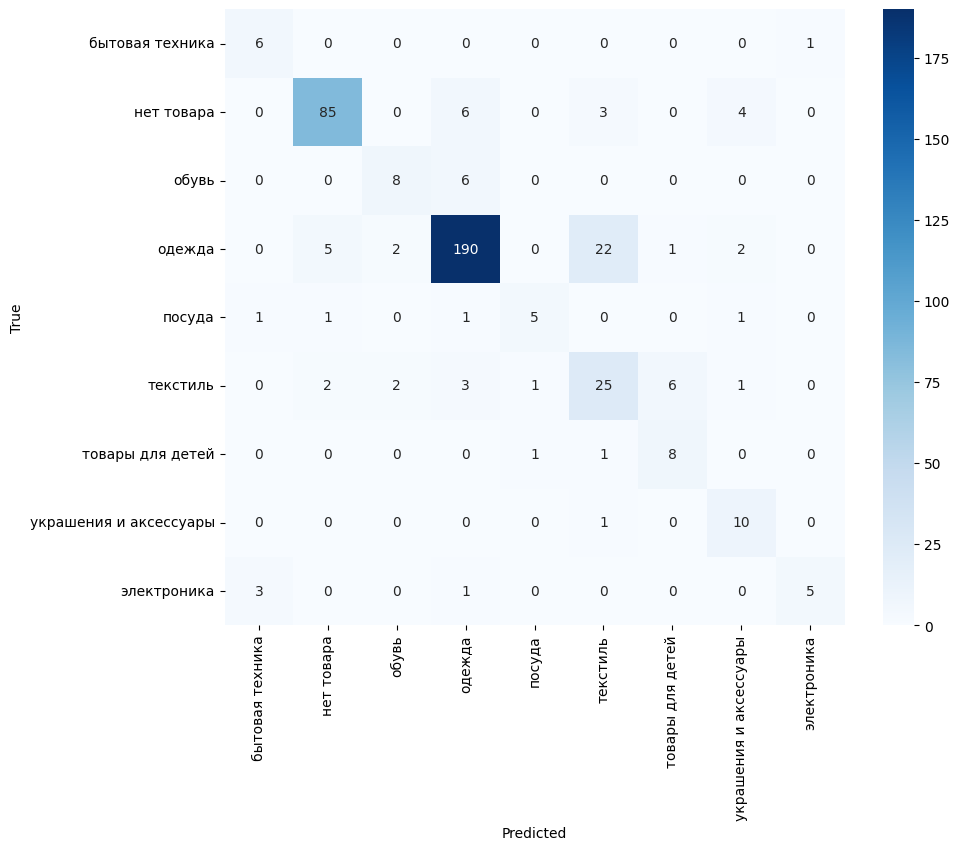

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Анализ ошибок на тестовой выборке ---")

# Получаем предсказания для тестового датасета
predictions = trainer.predict(tokenized_test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Получаем текстовые названия меток
predicted_categories = label_encoder.inverse_transform(predicted_labels)
true_categories = label_encoder.inverse_transform(true_labels)
class_names = label_encoder.classes_

# Отчет о классификации
print("\nClassification Report:")
print(classification_report(true_categories, predicted_categories, target_names=class_names))

# Матрица ошибок
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(true_categories, predicted_categories, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Собственно видим по результатом теста что, ну, проблема обычная - путаем текстиль и одежду, немного - бытовую технику и электронику. В целом выглядит нормально. f1 очевидно лучший на одежде и нет товара- что в целом для оценки хорошо, по другим категориям местами проседает сильно. Есть возможности для развития

In [13]:
# Пример работы
from transformers import pipeline

print("Проверка инференса на обученной XLM-R модели")
classifier = pipeline("text-classification", model="./best_review_classifier_xlm_large", device=0)

# Пример на русском
sample_text_ru = "Продавцу бальшое спасибо, сына играется уже 13 часов без остановки"
# Пример на английском
sample_text_en = "The screen of this laptop is too dim, very disappointed."

# Проверка на русском
start_time_ru = time.time()
result_ru = classifier(sample_text_ru)
end_time_ru = time.time()
print(f"Текст (RU): '{sample_text_ru}'")
print(f"Предсказание: {result_ru[0]['label']} (уверенность: {result_ru[0]['score']:.4f})")
print(f"Время инференса (RU): {end_time_ru - start_time_ru:.4f} секунд.")

# Проверка на английском
start_time_en = time.time()
result_en = classifier(sample_text_en)
end_time_en = time.time()
print(f"\nТекст (EN): '{sample_text_en}'")
# Модель должна предсказать 'электроника' или 'бытовая техника'
print(f"Предсказание: {result_en[0]['label']} (уверенность: {result_en[0]['score']:.4f})")
print(f"Время инференса (EN): {end_time_en - start_time_en:.4f} секунд.")


--- Проверка инференса на обученной XLM-R модели ---


Device set to use cuda:0


Текст (RU): 'Продавцу бальшое спасибо, сына играется уже 13 часов без остановки'
Предсказание: товары для детей (уверенность: 0.5471)
Время инференса (RU): 0.2131 секунд.

Текст (EN): 'The screen of this laptop is too dim, very disappointed.'
Предсказание: электроника (уверенность: 0.6259)
Время инференса (EN): 0.0273 секунд.


Видим что на GPU время работы крайне мало. Вообще говоря в 250 раз меньше времени чем лимит в задаче

In [14]:
!zip -r /kaggle/working/best_review_classifier.zip /kaggle/working/best_review_classifier_xlm_large

  adding: kaggle/working/best_review_classifier_xlm_large/ (stored 0%)
  adding: kaggle/working/best_review_classifier_xlm_large/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 20%)
  adding: kaggle/working/best_review_classifier_xlm_large/sentencepiece.bpe.model (deflated 49%)
  adding: kaggle/working/best_review_classifier_xlm_large/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/best_review_classifier_xlm_large/config.json (deflated 70%)
  adding: kaggle/working/best_review_classifier_xlm_large/training_args.bin (deflated 51%)
  adding: kaggle/working/best_review_classifier_xlm_large/tokenizer.json (deflated 76%)
  adding: kaggle/working/best_review_classifier_xlm_large/tokenizer_config.json (deflated 76%)


In [16]:
from IPython.display import FileLink, display
display(FileLink('./best_review_classifier.zip'))

/kaggle/working/best_review_classifier.zip

# Прогоняем тестовый датасет

Ну и финальный этап - инференс тестовых данных. Ничего особого - загружаем данные, загружаем модель и прогоняем весь датасет через модель

In [5]:
import pandas as pd
import torch
from transformers import pipeline
from tqdm import tqdm

MODEL_PATH = "/kaggle/input/final_model/transformers/default/1/kaggle/working/best_review_classifier_xlm_large"

# Путь к выходному файлу с результатами
OUTPUT_CSV_PATH = "test_predictions.csv"

BATCH_SIZE = 16


test_df = test.copy(deep=True)

print(f"Загружено {len(test_df)} записей для инференса.")

2025-09-17 15:13:36.127061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758122016.496989      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758122016.599861      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Загружено 7276 записей для инференса.


In [6]:
# ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ

DEVICE = 0 if torch.cuda.is_available() else -1
print(f"Используемое устройство: {'GPU' if DEVICE == 0 else 'CPU'}")
print(f"Загрузка модели из папки: {MODEL_PATH}")
try:
    classifier = pipeline(
        "text-classification",
        model=MODEL_PATH,
        tokenizer=MODEL_PATH,
        device=DEVICE
    )
    print("Модель успешно загружена.")
except Exception as e:
    print(f"ОШИБКА: Не удалось загрузить модель. Убедитесь, что путь '{MODEL_PATH}' корректен.")
    print(f"Детали ошибки: {e}")
    exit()

Используемое устройство: GPU
Загрузка модели из папки: /kaggle/input/final_model/transformers/default/1/kaggle/working/best_review_classifier_xlm_large


Device set to use cuda:0


Модель успешно загружена.


In [12]:
# --- 4. ЗАПУСК ИНФЕРЕНСА ---
texts_to_classify = test_df['clean_text'].tolist()

print(f"\nНачинаю классификацию {len(texts_to_classify)} отзывов...")
predictions = []
start_time = time.time()
for out in tqdm(classifier(texts_to_classify, batch_size=BATCH_SIZE, truncation=True), total=len(texts_to_classify)):
    predictions.append(out)
end_time = time.time()
print(f"Классификация завершена, время на обработку: {(end_time - start_time)}, среднее {(end_time - start_time) / len(texts_to_classify)}")


predicted_labels = [pred['label'] for pred in predictions]
confidence_scores = [pred['score'] for pred in predictions]

results_df = test_df.copy()

results_df['predicted_category'] = predicted_labels
results_df['confidence_score'] = confidence_scores

print(f"\nСохранение результатов в файл: {OUTPUT_CSV_PATH}")

submission_df = results_df[["predicted_category"]].copy()
submission_df_ = submission_df.rename(columns={"predicted_category": "category"})
submission_df_.to_csv(OUTPUT_CSV_PATH, encoding="utf-8-sig", index=False)

print("✅ Готово! Результаты успешно сохранены.")
print("\nПример итоговых данных:")
print(results_df.head())


Начинаю классификацию 7276 отзывов...


100%|██████████| 7276/7276 [00:00<00:00, 3593706.54it/s]

Классификация завершена, время на обработку: 103.97278499603271, среднее 0.014289827514572941

Сохранение результатов в файл: test_predictions.csv
✅ Готово! Результаты успешно сохранены.

Пример итоговых данных:
                                       original_text  \
0                                   Советую продавца   
1  По вашему это платье???? Это узкая кофта !!!! ...   
2  Жуткая синтетика. Неприятная ткань. Летом не п...   
3  Джемперок так себе на хилую четверку,запах гол...   
4  обычная х/б рубашка.не плотная,просвечивает ни...   

                                          clean_text predicted_category  \
0                                   советую продавца         нет товара   
1  по вашему это платье ? это узкая кофта ! за та...             одежда   
2  жуткая синтетика . неприятная ткань . летом не...           текстиль   
3  джемперок так себе на хилую четверку , запах г...             одежда   
4  обычная х/б рубашка . не плотная , просвечивае...             одежда   



## **Менее 15 мс на запрос в среднем!**
Результат очень хороший, ощутимо более быстрый инференс чем decoder-only модели, гарантированный выход и (с некоторыми оговорками) сопоставимое качество!

In [27]:
results_df["predicted_category"].value_counts()

predicted_category
одежда                    4438
нет товара                1890
текстиль                   690
обувь                      146
украшения и аксессуары      56
товары для детей            29
посуда                      18
электроника                  6
бытовая техника              3
Name: count, dtype: int64

In [33]:
results_df[results_df["predicted_category"] == "электроника"]["original_text"].tolist()

['ДЕРЖИТ РОВНО ПЯТЬ МИНУТ, ПОТОМ ОТЛИПАЕТ\r\r\nНЕ ПОКУПАЙТЕ, ПУСТАЯ ТРАТА ДЕНЕГ',
 'Качество плохое ,просвечиват,пришла с затяжкой .',
 'просвечивается, не советую',
 'Пришли уже со стрелками, обидно. Но и цена, конечно, смешная.',
 'В принципе,за такую цену очень даже ничего',
 'не соответствуют описанию!зелёного лампаса нет,только две белые полосы((((']

# Потенциал для развития  
Очевидно, что решение не идеальное. Есть несколько вещей которые можно улучшить:
* БОльшие модели, чтобы получить более качественную разметку датасета и/или более органичные синтетические данные
* Улучшенный промптинг (местами инструкции неидеальны, по-хорошему их надо докрутить)
* Использование decoder-only модели как классификатора (несмотря на некоторую нестабильность, можно попробовать дистиллировать данные из большой модели в маленькую модель, чтобы заставить ее выдавать стабильно только класс отзыва)
* Активное обучение (и при разметке, и при классификации)
* ВНЕ УСЛОВИЙ ОТБОРА Ручной сбор данных: ии разметка хороша, но ручной разметкой можно больше снизить ошибку на этом этапе, и конечно очень разумно собрать честный датасет, в котором будет достаточное разнообразие отзывов на все классы